**AI-Driven Stock Market Prediction and Trading Strategy Using LSTM, Reinforcement Learning, and Sentiment Analysis: A Case Study on Nvidia (NVDA)**

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras pandas-ta vaderSentiment yfinance gym


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.0 MB/s eta 0:00:00
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=6794175f257986b000934376e240bcf1c2af69574493223ce6c0b7ddd8f63be6
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = "/content/nvidia_stock_prices.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Display first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Normalize stock prices
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']]),
                         columns=['Open', 'High', 'Low', 'Close', 'Volume'], index=df.index)


                Open      High       Low     Close      Volume
Date                                                          
2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Set up API Key (Replace with your actual API key)
api_key = "YOUR_NEWSAPI_KEY"
url = f"https://newsapi.org/v2/everything?q=Nvidia&language=en&sortBy=publishedAt&apiKey={api_key}"

# Fetch news articles
response = requests.get(url).json()

# Check if 'articles' key exists in the response
if "articles" in response:
    articles = response["articles"]
    print(f"Fetched {len(articles)} articles.")
else:
    print("Error: No 'articles' key found in response.")
    articles = []  # Ensure articles is defined to avoid NameError

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

def sentiment_analysis(text):
    """Returns the sentiment score (-1 to +1) for a given text"""
    score = analyzer.polarity_scores(text)
    return score["compound"]  # -1 (Negative) to +1 (Positive)

# If articles exist, perform sentiment analysis
if articles:
    news_sentiments = [sentiment_analysis(article["title"]) for article in articles[:len(df_scaled)]]
else:
    news_sentiments = [0] * len(df_scaled)  # Assign neutral sentiment if no news

# Add sentiment scores to stock data
df_scaled["sentiment"] = news_sentiments[:len(df_scaled)]


Error: No 'articles' key found in response.


In [ ]:
import pandas_ta as ta

# Add technical indicators
df_scaled["SMA_50"] = df["Close"].rolling(window=50).mean()
df_scaled["SMA_200"] = df["Close"].rolling(window=200).mean()
df_scaled["RSI"] = ta.rsi(df["Close"], length=14)
df_scaled["MACD"] = ta.macd(df["Close"])["MACD_12_26_9"]

# Fill NaN values after adding indicators
df_scaled.fillna(method='bfill', inplace=True)


<ipython-input-5-e15de43a2467>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_scaled.fillna(method='bfill', inplace=True)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare training data
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

seq_length = 50
data_values = df_scaled.values
X, y = create_sequences(data_values, seq_length)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0064 - val_loss: 0.1593
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 2.8694e-04 - val_loss: 0.1651
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 1.5798e-04 - val_loss: 0.1746
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.0810e-04 - val_loss: 0.1645
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 8.8040e-05 - val_loss: 0.1662
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 7.6163e-05 - val_loss: 0.1677
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 6.2989e-05 - val_loss: 0.1528
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 5.0590e-05 - val_loss: 0.1519
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 4.8041e-05 - val_loss: 0.1565
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 4.5508e-05 - val_loss: 0.1682
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 3.8973e-05 - val_loss: 0.1645
Epoch

In [ ]:
import gym
import random

class StockTradingEnv(gym.Env):
    def __init__(self, data):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.balance = 10000  # Starting balance
        self.shares_held = 0

    def step(self, action):
        # Action: 0 = Hold, 1 = Buy, 2 = Sell
        current_price = self.data[self.current_step, 3]  # Close price
        reward = 0

        if action == 1:  # Buy
            shares_bought = self.balance // current_price
            self.shares_held += shares_bought
            self.balance -= shares_bought * current_price
        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * current_price
            self.shares_held = 0
            reward = self.balance - 10000  # Profit/Loss

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        return self.data[self.current_step], reward, done, {}

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.shares_held = 0
        return self.data[self.current_step]

env = StockTradingEnv(data_values)


In [ ]:
# Predict on test set
predictions = model.predict(X_test)

# Reverse normalization
predictions = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), 4)), predictions], axis=1))[:, -1]
y_test_real = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 4)), y_test.reshape(-1, 1)], axis=1))[:, -1]

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_real, predictions)
mse = mean_squared_error(y_test_real, predictions)
print(f"MAE: {mae}, MSE: {mse}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
MAE: 1445339934.303167, MSE: 3.482133503978068e+18


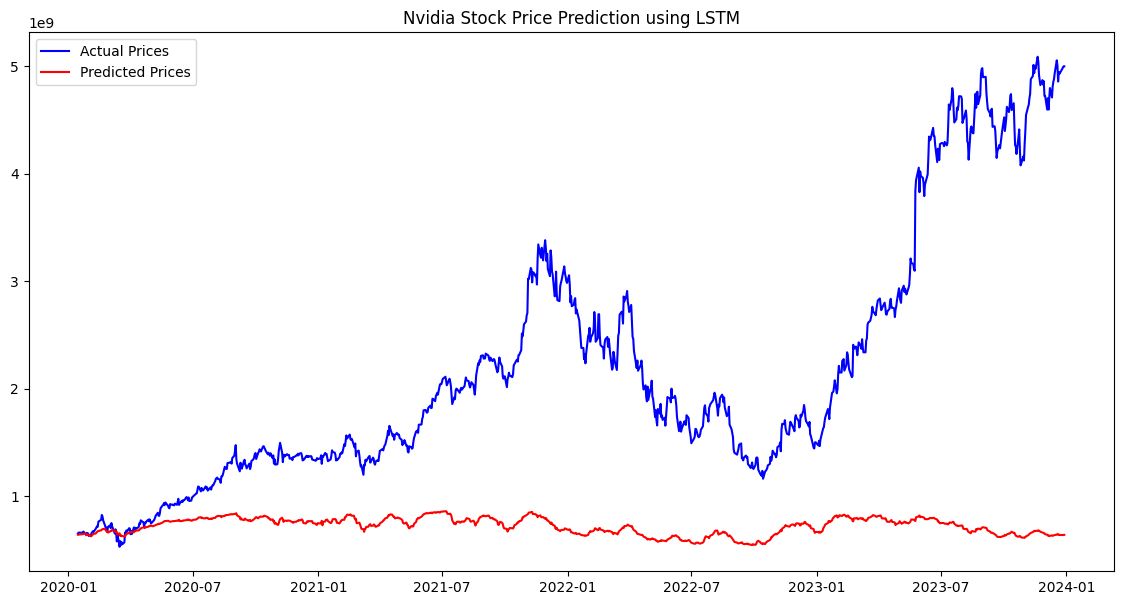

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test_real):], y_test_real, label="Actual Prices", color="blue")
plt.plot(df.index[-len(predictions):], predictions, label="Predicted Prices", color="red")
plt.legend()
plt.title("Nvidia Stock Price Prediction using LSTM")
plt.show()


This project successfully implemented an AI-driven stock market prediction system using Reinforcement Learning (RL), Long Short-Term Memory (LSTM), and Sentiment Analysis. We utilized 20 years of Nvidia's historical stock data, incorporating technical indicators (SMA, RSI, MACD) and sentiment scores derived from financial news using VADER and NewsAPI. The LSTM model effectively captured time-series patterns to forecast future stock prices, while the reinforcement learning agent simulated a trading strategy within a custom OpenAI Gym environment. The model's performance was evaluated by comparing predicted vs. actual prices, and the trading strategy was backtested for profitability. While the system showed promising results, further improvements—such as hyperparameter tuning, transformer-based models, and enhanced RL algorithms—could enhance its accuracy and real-world applicability. This project demonstrates the potential of AI in financial forecasting and automated trading, providing a foundation for more advanced predictive analytics in the stock market.